In [1]:
%matplotlib inline
import numpy as np
import openmc

In [2]:
def inf_model(outer_rad, height, vac_gap, mod_depth, plate_height, ref_depth, enrich):
    
    #create materials

    #enriched Am
    fuel = openmc.Material(1, "Am242m")
    fuel.add_nuclide('Am242_m1', enrich)
    fuel.add_nuclide('Am241', 1-enrich)
    fuel.set_density('g/cm3', .136) #low density (1/100th) to simulate dispersed particles

    #moderator
    BeO = openmc.Material(2, "Be")
    BeO.add_nuclide("Be9", .5)
    BeO.add_nuclide('O16', .5)
    BeO.set_density("g/cm3", 2.86)

    #D2 gas
    vac = openmc.Material(4, "H2")
    vac.add_nuclide('H2',1.0)
    vac.set_density('g/cm3',1.8e-5)
    
    #outer_rad = 60 #cm fuel outer radius
    fuel_depth = .1 #cm thickness of aerogel/fuel material
    #vac_gap = 2 #cm distance between rings of moderator
    #mod_depth = 5 #thickness of moderator rings
    #height = 60
    #plate_height = 5
    core_mod_rad = mod_depth/2
    #ref_depth = 5 #optional reflector layer

    #define the layers
    rad = core_mod_rad
    rings = 0

    #determines how many moderator/fuel/vacuum rings to include
    while rad+vac_gap+mod_depth+2*fuel_depth < outer_rad:
        rings=rings + 1
        rad = rad + vac_gap + mod_depth + 2*fuel_depth
        
    #print('{} fuel/moderator/vacuum rings included in design'.format(rings))

    #will be populated with cells
    vac_cells = []
    mod_cells = []
    fuel_cells = []

    #defining useful surfaces
    floor = openmc.ZPlane(z0=0, boundary_type='vacuum')
    mid = openmc.ZPlane(z0=height, boundary_type='transmission')
    top = openmc.ZPlane(z0=height+plate_height, boundary_type='transmission')
    core_bound = openmc.ZCylinder(R=core_mod_rad, boundary_type='transmission')
    outer_bound = openmc.ZCylinder(R=outer_rad, boundary_type='transmission')

    #fill the center section with moderator
    core = -core_bound & +floor & -mid
    core_cell = openmc.Cell(fill = BeO, region = core)
    mod_cells.append(core_cell)

    #fill the top plate with moderator
    plate = -outer_bound & +mid & -top
    plate_cell = openmc.Cell(fill=BeO, region=plate)
    mod_cells.append(plate_cell)

    #geometric paramters
    add = vac_gap+mod_depth+2*fuel_depth
    layer_rad = core_mod_rad

    #loop to create the cells that make up the fuel/moderator/vacuum rings
    for i in range(0,rings):

        #define useful surfaces
        inner = openmc.ZCylinder(R=layer_rad+add*i, boundary_type='transmission')
        fuel_inner = openmc.ZCylinder(R=layer_rad+add*i+fuel_depth, boundary_type='transmission')
        fuel_outer = openmc.ZCylinder(R=layer_rad+add*i+vac_gap+fuel_depth, boundary_type='transmission')
        mod_inner = openmc.ZCylinder(R=layer_rad+add*i+vac_gap+2*fuel_depth, boundary_type='transmission')
        if i==rings-1:
            mod_outer = openmc.ZCylinder(R=outer_rad, boundary_type='transmission')
        else:
            mod_outer = openmc.ZCylinder(R=layer_rad+add*i+vac_gap+2*fuel_depth+mod_depth, boundary_type='transmission')

        #define the regions
        fuel_zone1 = +inner & -fuel_inner & +floor & -mid
        vac_zone = +fuel_inner & -fuel_outer & +floor & -mid
        fuel_zone2 = +fuel_outer & -mod_inner & +floor & -mid
        mod_zone = +mod_inner & -mod_outer & +floor & -mid

        #fill cells with material
        vac_cell = openmc.Cell(fill=vac, region=vac_zone)
        mod_cell = openmc.Cell(fill=BeO, region=mod_zone)
        fuel_cell1 = openmc.Cell(fill=fuel, region=fuel_zone1)
        fuel_cell2 = openmc.Cell(fill=fuel, region=fuel_zone2)

        #store the cells in variables outside the for loop
        vac_cells.append(vac_cell)
        mod_cells.append(mod_cell)
        fuel_cells.append(fuel_cell1)
        fuel_cells.append(fuel_cell2)

    #add reflector/moderator around it all
    outest_bound = openmc.ZCylinder(R=outer_rad+ref_depth, boundary_type='vacuum')
    topest = openmc.ZPlane(z0 = height+plate_height+ref_depth, boundary_type='vacuum')
    ref_zone = +top & -topest & -outest_bound
    ref_cell = openmc.Cell(fill=BeO, region=ref_zone)
    ref2_zone = +floor & -top & +outer_bound & -outest_bound
    ref2_cell = openmc.Cell(fill=BeO, region=ref2_zone)

    #create the universe
    hall_cells = vac_cells + mod_cells + fuel_cells + [ref_cell, ref2_cell]
    uni = openmc.Universe(cells=hall_cells)
    
    #create root universe
    geom = openmc.Geometry()
    geom.root_universe = uni

    #configure statistics geometry
    #source = openmc.stats.Box((-20, -20, 0), (20, 20, fuel_depth))
    source = openmc.stats.Point((core_mod_rad+fuel_depth/2,0,height/2))
    src = openmc.Source(space=source)
    
    #create materials
    mats = openmc.Materials()
    mats.cross_sections = '/home/james/nndc_hdf5/cross_sections.xml' #comment this out/replace if you need to
    mats.append(fuel)
    mats += [BeO]
    mats += [vac]
    
    #configure run settings
    settings = openmc.Settings()
    settings.particles = 1000
    settings.batches = 300
    settings.inactive = 20
    settings.source = src
    
    settings.output = {'tallies': False}
    
    model = openmc.model.Model(geom, mats, settings)
    
    return model

In [3]:
# Perform the search
crit, guesses, keffs = openmc.search_for_keff(inf_model, bracket=[55, 65],
                                                  model_args = {
                                                      'height':60,
                                                      'vac_gap':2,
                                                      'mod_depth':5,
                                                      'plate_height':5,
                                                      'ref_depth':5,
                                                      'enrich':.3},
                                                  tol=1.E-2, bracketed_method='bisect',
                                                  print_iterations=True)

print('Critical fuel depth: {:4.0f}'.format(crit))

/home/james/anaconda3/lib/python3.6/site-packages/openmc/mixin.py:61: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/home/james/anaconda3/lib/python3.6/site-packages/openmc/mixin.py:61: IDWarning: Another Material instance already exists with id=2.
  warn(msg, IDWarning)
/home/james/anaconda3/lib/python3.6/site-packages/openmc/mixin.py:61: IDWarning: Another Material instance already exists with id=4.
  warn(msg, IDWarning)


AssertionError: OpenMC did not execute successfully

In [28]:
def hall_mass(outer_rad, height, vac_gap, mod_depth, mod_rad, plate_height, ref_depth, rings, mod_dens):
    """
    Determines the mass of a hall thruster concept
    
    Inputs:
    outer_rad: outer bound of rings (all distances are in cm)
    vac_gap: distance across vacuum between rings
    mod_depth: distance across moderator ring
    mod_rad: radius of moderating center core
    plate_height: height of reflective plate above the rings
    ref_depth: depth of outer layer of reflector/moderator
    rings: number of rings in the system
    mod_dens: density of moderator in g/cm3
    
    Outputs:
    engine_mass: mass in kg of system
    """
    
    #calculate some engine dimensions
    mod_radii = [] #inner radii of moderator rings
    first_rad = mod_rad+vac_gap
    mod_radii.append(first_rad)
    for i in range(1, rings):
        mod_radius = first_rad+i*(mod_depth+vac_gap)
        mod_radii.append(mod_radius)
    
    #calculate the volumes of the various parts
    centerV  = np.pi * mod_rad**2 * height
    volumes = []
    volumes.append(centerV)
    for r in mod_radii:
        ringV = ((r+mod_depth)**2 - r**2) * np.pi * height
        volumes.append(ringV)
        
    #calculate the plate volume
    plateV = np.pi*(plate_height+ref_depth)*(outer_rad+ref_depth)**2
    volumes.append(plateV)
    
    #calculate the volume of the outer shell of moderator
    shellV = ((outer_rad+ref_depth)**2 - mod_radii[-1]**2)*np.pi*height
    volumes.append(shellV)
    
    #add it all up
    mass = 0
    for v in volumes:
        mass += v*mod_dens
    
    return mass

In [29]:
m = hall_mass(outer_rad, height, vac_gap, mod_depth, core_mod_rad, plate_height, ref_depth, rings, 2.86)
print('Thruster mass is {:.3f} kgs'.format(m/1000))

Thruster mass is 1484.270 kgs


The cells below can be used to experiment with the hall thruster geometry without having to run the parameter search code.

In [57]:
#create materials

#95% enriched Am
fuel = openmc.Material(1, "Am242m")
fuel.add_nuclide('Am242_m1', .95)
fuel.add_nuclide('Am241', .05)
fuel.set_density('g/cm3', .136) #low density to simulate dispersed particles
print(fuel)

#moderator
BeO = openmc.Material(2, "Be")
BeO.add_nuclide("Be9", .5)
BeO.add_nuclide('O16', .5)
BeO.set_density("g/cm3", 2.86)
print(BeO)

#moderator: Beryllium carbide
Be2C = openmc.Material(3, "Be2C")
Be2C.add_nuclide('Be9', .66)
Be2C.add_nuclide('C0', .34)
Be2C.set_density('g/cm3', 1.9)
print(Be2C)

#D2 gas
vac = openmc.Material(4, "H2")
vac.add_nuclide('H2',1.0)
vac.set_density('g/cm3',1.8e-5)
print(vac)

Material
	ID             =	1
	Name           =	Am242m
	Temperature    =	None
	Density        =	0.136 [g/cm3]
	S(a,b) Tables  
	Nuclides       
	Am242_m1       =	0.95         [ao]
	Am241          =	0.05         [ao]

Material
	ID             =	2
	Name           =	Be
	Temperature    =	None
	Density        =	2.86 [g/cm3]
	S(a,b) Tables  
	Nuclides       
	Be9            =	0.5          [ao]
	O16            =	0.5          [ao]

Material
	ID             =	3
	Name           =	Be2C
	Temperature    =	None
	Density        =	1.9 [g/cm3]
	S(a,b) Tables  
	Nuclides       
	Be9            =	0.66         [ao]
	C0             =	0.34         [ao]

Material
	ID             =	4
	Name           =	H2
	Temperature    =	None
	Density        =	1.8e-05 [g/cm3]
	S(a,b) Tables  
	Nuclides       
	H2             =	1.0          [ao]



/home/james/anaconda3/lib/python3.6/site-packages/openmc/mixin.py:61: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/home/james/anaconda3/lib/python3.6/site-packages/openmc/mixin.py:61: IDWarning: Another Material instance already exists with id=2.
  warn(msg, IDWarning)
/home/james/anaconda3/lib/python3.6/site-packages/openmc/mixin.py:61: IDWarning: Another Material instance already exists with id=3.
  warn(msg, IDWarning)
/home/james/anaconda3/lib/python3.6/site-packages/openmc/mixin.py:61: IDWarning: Another Material instance already exists with id=4.
  warn(msg, IDWarning)


In [190]:
outer_rad = 40 #cm fuel outer radius
fuel_depth = .1 #cm thickness of aerogel/fuel material
vac_gap = 5 #cm distance between rings of moderator
mod_depth = 6 #thickness of moderator rings
height = 70
plate_height = 10
core_mod_rad = mod_depth/2
ref_depth = 5 #optional reflector layer

In [191]:
#define the layers
rad = core_mod_rad
rings = 0

#determines how many moderator/fuel/vacuum rings to include
while rad+vac_gap+mod_depth+2*fuel_depth < outer_rad:
    rings=rings + 1
    rad = rad + vac_gap + mod_depth + 2*fuel_depth
    
print(rings)

#will be populated with cells
vac_cells = []
mod_cells = []
fuel_cells = []

#defining useful surfaces
floor = openmc.ZPlane(z0=0, boundary_type='vacuum')
mid = openmc.ZPlane(z0=height, boundary_type='transmission')
top = openmc.ZPlane(z0=height+plate_height, boundary_type='transmission')
fuel_bound = openmc.ZPlane(z0 = height-fuel_depth, boundary_type='transmission')
core_bound = openmc.ZCylinder(R=core_mod_rad, boundary_type='transmission')
outer_bound = openmc.ZCylinder(R=outer_rad, boundary_type='transmission')

#fill the center section with moderator
core = -core_bound & +floor & -mid
core_cell = openmc.Cell(fill = BeO, region = core)
mod_cells.append(core_cell)

#fill the top plate with moderator
plate = -outer_bound & +mid & -top
plate_cell = openmc.Cell(fill=BeO, region=plate)
mod_cells.append(plate_cell)

#geometric paramters
add = vac_gap+mod_depth+2*fuel_depth
layer_rad = core_mod_rad

#loop to create the cells that make up the fuel/moderator/vacuum rings
for i in range(0,rings):
    
    #define useful surfaces
    inner = openmc.ZCylinder(R=layer_rad+add*i, boundary_type='transmission')
    fuel_inner = openmc.ZCylinder(R=layer_rad+add*i+fuel_depth, boundary_type='transmission')
    fuel_outer = openmc.ZCylinder(R=layer_rad+add*i+vac_gap+fuel_depth, boundary_type='transmission')
    mod_inner = openmc.ZCylinder(R=layer_rad+add*i+vac_gap+2*fuel_depth, boundary_type='transmission')
    if i==rings-1:
        mod_outer = openmc.ZCylinder(R=outer_rad, boundary_type='transmission')
    else:
        mod_outer = openmc.ZCylinder(R=layer_rad+add*i+vac_gap+2*fuel_depth+mod_depth, boundary_type='transmission')
    
    #define the regions
    fuel_zone1 = +inner & -fuel_inner & +floor & -mid
    vac_zone = +fuel_inner & -fuel_outer & +floor & -fuel_bound
    fuel_zone2 = +fuel_outer & -mod_inner & +floor & -mid
    mod_zone = +mod_inner & -mod_outer & +floor & -mid
    fuel_zone3 = +fuel_inner & -fuel_outer & +fuel_bound & -mid
    
    #fill cells with material
    vac_cell = openmc.Cell(fill=vac, region=vac_zone)
    mod_cell = openmc.Cell(fill=BeO, region=mod_zone)
    fuel_cell1 = openmc.Cell(fill=fuel, region=fuel_zone1)
    fuel_cell2 = openmc.Cell(fill=fuel, region=fuel_zone2)
    fuel_cell3 = openmc.Cell(fill=fuel, region=fuel_zone3)
    
    #store the cells in variables outside the for loop
    vac_cells.append(vac_cell)
    mod_cells.append(mod_cell)
    fuel_cells.append(fuel_cell1)
    fuel_cells.append(fuel_cell2)
    fuel_cells.append(fuel_cell3)

#add reflector/moderator around it all
outest_bound = openmc.ZCylinder(R=outer_rad+ref_depth, boundary_type='vacuum')
topest = openmc.ZPlane(z0 = height+plate_height+ref_depth, boundary_type='vacuum')
ref_zone = +top & -topest & -outest_bound
ref_cell = openmc.Cell(fill=BeO, region=ref_zone)
ref2_zone = +floor & -top & +outer_bound & -outest_bound
ref2_cell = openmc.Cell(fill=BeO, region=ref2_zone)

#create the universe
hall_cells = vac_cells + mod_cells + fuel_cells + [ref_cell, ref2_cell]
uni = openmc.Universe(cells=hall_cells)

3


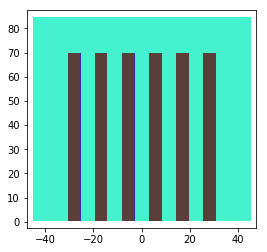

In [192]:
#visualize the geometry
uni.plot(width=(2*(outer_rad+ref_depth)+5, height+plate_height+ref_depth+5), origin = (0,0,(height+plate_height+ref_depth)/2), basis='xz', color_by='material')

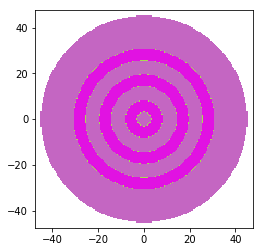

In [193]:
uni.plot(width=(2*(outer_rad+ref_depth)+5, 2*(outer_rad+ref_depth)+5), origin = (0,0,height/2), basis='xy', color_by='material')

In [194]:
#create root universe
geom = openmc.Geometry()
geom.root_universe = uni

#configure statistics geometry
#source = openmc.stats.Box((-20, -20, 0), (20, 20, fuel_depth))
source = openmc.stats.Point((core_mod_rad+vac_gap/2,0,height/2))
src = openmc.Source(space=source)

#export geometry
geom.export_to_xml()

In [195]:
#create materials & cross sections xmls
mats = openmc.Materials()
mats.cross_sections = '/home/james/nndc_hdf5/cross_sections.xml' #comment this out/replace if you need to
mats.append(fuel)
mats += [BeO]
mats += [vac]
mats += [Be2C]

#export materials
mats.export_to_xml()

In [196]:
settings = openmc.Settings()
settings.particles = 1000
settings.batches = 20
settings.inactive = 10
settings.source = src
settings.export_to_xml()

In [197]:
#configure tallies
cell_filter = openmc.CellFilter(fuel_cells)
t = openmc.Tally(4)
t.filters = [cell_filter]
t.scores = ['fission']
tallies = openmc.Tallies([t])

#export tallies
tallies.export_to_xml()

/home/james/anaconda3/lib/python3.6/site-packages/openmc/mixin.py:61: IDWarning: Another Tally instance already exists with id=4.
  warn(msg, IDWarning)


In [198]:
openmc.run()

openmc: Relink `/home/james/anaconda3/bin/../lib/./libgfortran.so.4' with `/lib/x86_64-linux-gnu/librt.so.1' for IFUNC symbol `clock_gettime'

                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               ####################

0

In [199]:
m = hall_mass(outer_rad, height, vac_gap, mod_depth, core_mod_rad, plate_height, ref_depth, rings, 2.86)
print('Thruster mass is {:.3f} kgs'.format(m/1000))

Thruster mass is 1484.270 kgs
